<a href="https://colab.research.google.com/github/Preetitamrakar-phd/Internship-At-The-Sparks-Foundation-/blob/main/Task7_StockMarketPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DATA SCIENCE AND BUSINESS ANALYTICS INTERN at SPARKS FOUNDATION #GRIPJAN21**

**Preeti Tamrakar**

**Task #7**

# **To Do:** Stock Market Prediction using Numerical and Textual Analysis


Create a hybrid model for stock price/performance
prediction using 
1. numerical analysis of historical stock prices by using  historical stock prices dataset from finance.yahoo.com, and
2. sentimental analysis of news headlines by using textual (news) data from https://bit.ly/36fFPI6

Stock to analyze and predict: SENSEX (S&P BSE SENSEX) (I have provided this dataset in my GitHub Repository)<br>  

Date: 01-01-2006 to 31-12-2010

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime                       # To handle time series data
from statsmodels.tsa.arima_model import ARIMA     # An ARIMA model is a class of statistical models for analyzing and forecasting time series data
from sklearn.metrics import mean_squared_error


**Time series data**, also referred to as time-stamped data, is a sequence of data points indexed in time order. <Br>
These data points typically consist of successive measurements made from the same source over a time interval and are used to track change over time. <br>
It is a collection of observations obtained through repeated measurements over time.<br>
When we plot the points on a graph, then one of our axis would always be time.<br>
Examples of time series are heights of ocean tides, counts of sunspots, and the daily closing value of the stock market index.

In [2]:
from google.colab import files
uploaded = files.upload()

Saving BSESN.csv to BSESN (1).csv


In [3]:
df = pd.read_csv("BSESN.csv")
df.replace(np.nan, inplace=True)
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2006-01-02,9422.490234,9457.089844,9366.089844,9390.139648,9390.139648,14000.0
1,2006-01-03,9401.830078,9546.780273,9390.790039,9539.370117,9539.370117,13200.0
2,2006-01-04,9523.290039,9664.940430,9523.290039,9648.080078,9648.080078,21400.0
3,2006-01-05,9638.269531,9679.719727,9571.309570,9617.740234,9617.740234,19200.0
4,2006-01-06,9635.089844,9680.919922,9535.660156,9640.290039,9640.290039,16000.0


Our target is "Close" column. As we are doing time series analysis, we need only date and close columns only.

In [4]:
df = df[['Date','Close']] 
df.shape

(1234, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1234 entries, 0 to 1233
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1234 non-null   object 
 1   Close   1234 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.4+ KB


In [6]:
df['Date'] = pd.to_datetime(df.Date, format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1234 entries, 0 to 1233
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1234 non-null   datetime64[ns]
 1   Close   1234 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.4 KB


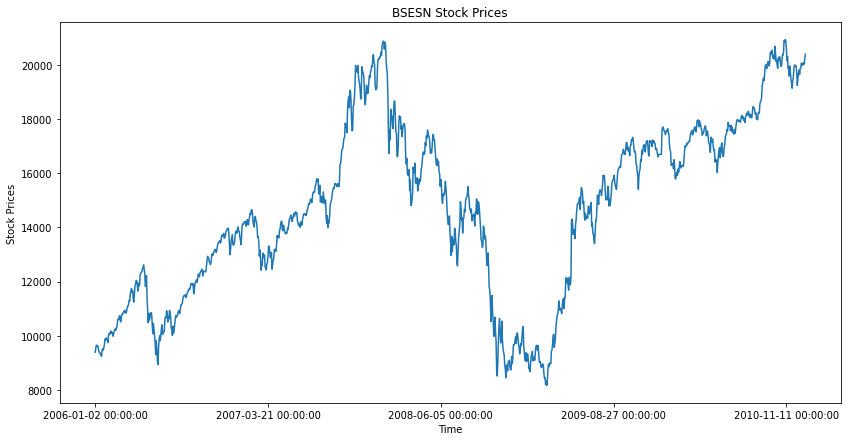

In [7]:
plt.figure(figsize=(14,7))
plt.xlabel('Time')
plt.ylabel('Stock Prices')
plt.title('BSESN Stock Prices')
plt.plot(df['Close'])
plt.xticks(np.arange(0,1500, 300), df['Date'][0:1500:300])
plt.show()

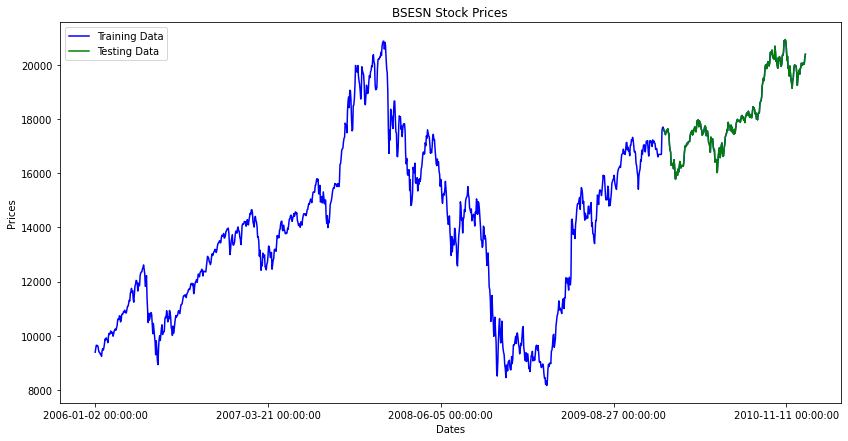

In [8]:
# Spliting the data into training and test sets with 80/20 ratio.
train_data, test_data = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):]
plt.figure(figsize=(14,7))
plt.title('BSESN Stock Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df['Close'], 'blue', label='Training Data')  # Blue indicates the training data 
plt.plot(test_data['Close'], 'green', label='Testing Data') # green indicates the test data
plt.xticks(np.arange(0,1500, 300), df['Date'][0:1500:300])
plt.legend()

### ARIMA

ARIMA (AutoRegressive Integrated Moving Average) is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.

ARIMA models explain a time series based on its own past values, basically its own lags and the lagged forecast errors.

An ARIMA model is characterized by 3 terms (p, d, q):

- p is the order of the AR (**AutoRegressive**) term

- d is the number of **differencing** required to make the time series stationary

- q is the order of the MA (**Moving Average**) term

As we see in the parameters required by the model, any stationary time series can be modeled with ARIMA models.



### Stationarity

A stationary time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times.

Subtract the previous value from the current value. Now if we just difference once, we might not get a stationary series so we might need to do that multiple times. 

And **the minimum number of differencing operations needed to make the series stationary needs to be imputed into our ARIMA model.**

### ADF test

We'll use the Augumented Dickey Fuller (ADF) test to check if the price series is stationary.

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then we can reject the null hypothesis and infer that the time series is indeed stationary.



In [9]:
# Check if price series is stationary
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.Close.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -1.4487894160317896
p-value: 0.5586754909640097


p-value > 0.05, therefore the time series is not stationary. So, in our case, if the p-value > 0.05 we'll need to find the order of differencing.

In [15]:
# !pip install pmdarima            #for google colab

  Using cached https://files.pythonhosted.org/packages/c9/d7/61af1897449638822f97c8b43ef0c2fce2ec68a6cda9a43ebbbdd12b967c/pmdarima-1.8.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/be/4c/9e2435ca6645d6bafa2b51bb11f0a365b28934a2ffe9d6e339d67130926d/statsmodels-0.12.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/e7/d7/510ddef0248f3e1e91f9cc7e31c0f35f8954d0af92c5c3fd4c853e859ebe/Cython-0.29.17-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


In [10]:
#!pip install --skip-lock pmdarima     # for jupyter notebook

from pmdarima.arima.utils import ndiffs
ndiffs(df.Close, test="adf")

1

Therefore d value is 1 

#### p

p is the order of the Auto Regressive (AR) term. It refers to the number of lags to be used as predictors. 

We can find out the required number of AR terms by inspecting the **Partial Autocorrelation (PACF)** plot.

The partial autocorrelation represents the correlation between the series and its lags. 

**To calculate p value, we are going for Partial Autocorrelation (PACF) plot.**

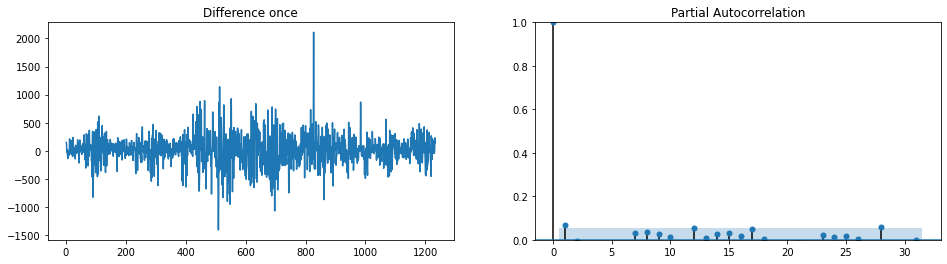

In [11]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2);

This point comes over the significance line i.e. 1, so we can say that p value is 1.

#### q

q is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.

We can look at the ACF plot for the number of MA terms.

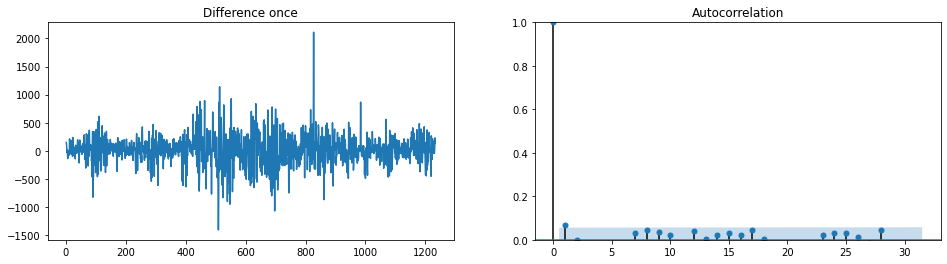

In [12]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2);

This point stands outside the significance line,  so the value of q is also 1. 

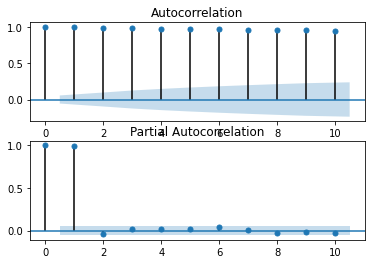

In [13]:
dataset=df.copy()
dataset.set_index('Date', inplace=True)
dataset = dataset[['Close']] 
from matplotlib import pyplot
pyplot.figure()
pyplot.subplot(211)
plot_acf(dataset, ax=pyplot.gca(),lags=10)
pyplot.subplot(212)
plot_pacf(dataset, ax=pyplot.gca(),lags=10)
pyplot.show()

**In order to evaluate the ARIMA model, I decided to use two different error functions: Mean Squared Error (MSE) and Symmetric Mean Absolute Percentage Error (SMAPE). SMAPE is commonly used as an accuracy measure based on relative errors.**

SMAPE is not currently supported in Scikit-learn as a loss function I, therefore, had first to create this function on my own.

In [14]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

![1_I3WbbaaUPe9Mn5WcUVEwwg.png](attachment:1_I3WbbaaUPe9Mn5WcUVEwwg.png)

In [15]:
train_ar = train_data['Close'].values
test_ar = test_data['Close'].values
history = [x for x in train_ar]
print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(2,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

<class 'list'>
Testing Mean Squared Error: 33910.563
Symmetric mean absolute percentage error: 8.380


SMAPE (Symmetric mean absolute percentage error) is commonly used loss function for Time Series problems and can, therefore, provide a more reliable analysis. That showed that our model is good.

In [16]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1232
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -8620.611
Method:                       css-mle   S.D. of innovations            264.623
Date:                Wed, 20 Jan 2021   AIC                          17251.221
Time:                        16:39:38   BIC                          17276.803
Sample:                             1   HQIC                         17260.845
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.8062      7.326      1.202      0.229      -5.553      23.165
ar.L1.D.y      0.7589      0.161      4.723      0.000       0.444       1.074
ar.L2.D.y     -0.0794      0.029     -2.765      0.0

Here we can see that all the p values are close to 0 means we can say our model is performing good. 

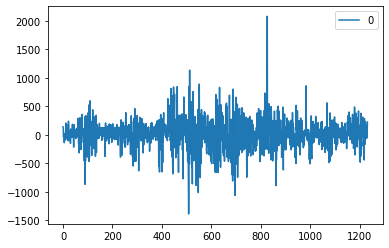

In [17]:
# checking the residual
residuals=pd.DataFrame(model_fit.resid)
residuals.plot()

Residuals are around 0 , that shows model is good.

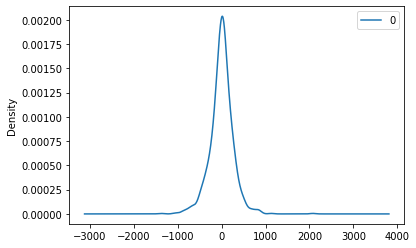

In [18]:
residuals.plot(kind='kde')

Here, residuals are normally distributed. 

In [19]:
residuals.describe()

,0
count,1232.000000
mean,0.008539
std,264.730673
min,-1389.410379
25%,-129.446038
50%,10.514457
75%,138.320967
max,2077.990387


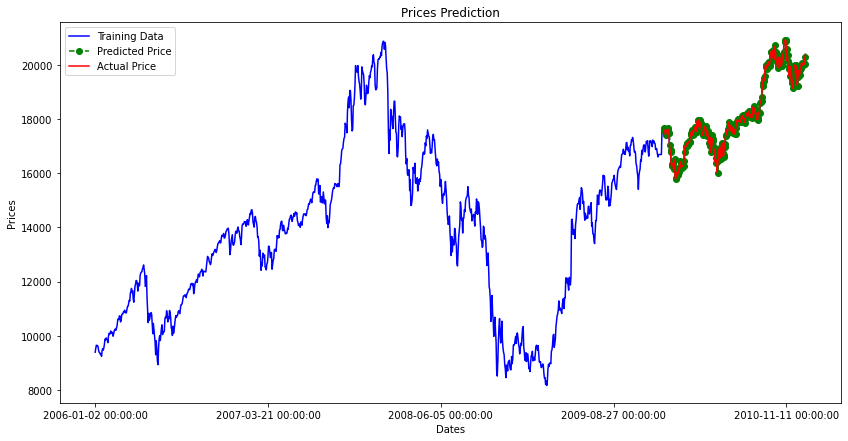

In [21]:
#Lets do prediction
plt.figure(figsize=(14,7))
plt.plot(df['Close'], 'green', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', label='Predicted Price')
plt.plot(test_data.index, test_data['Close'], color='red', label='Actual Price')
plt.title('Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(0,1500, 300), df['Date'][0:1500:300])
plt.legend()

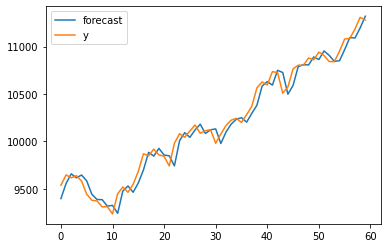

In [22]:
# Actual vs predicted for the first 60
model_fit.plot_predict(
    start=1,
    end=60,
    dynamic=False,
);

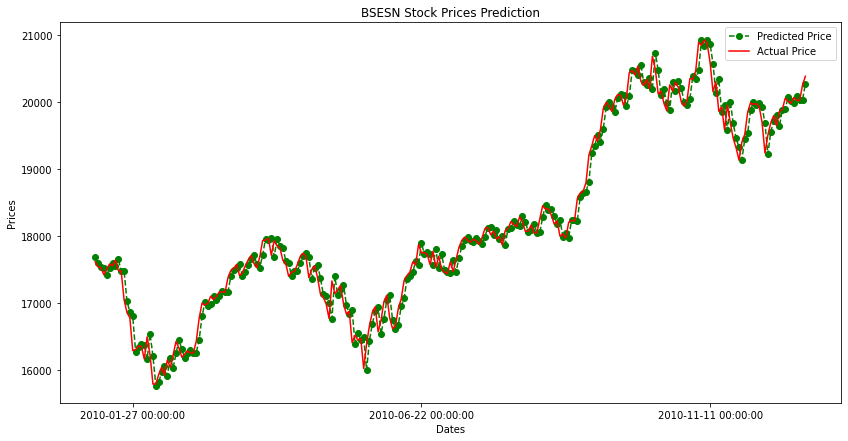

In [23]:
# Zooming the above area
plt.figure(figsize=(14,7))
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_data.index, test_data['Close'], color='red', label='Actual Price')
plt.legend()
plt.title('BSESN Stock Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(1000,1259,100), df['Date'][1000:1259:100])
plt.legend()

**The above image is a zoomed in version. From this can be noticed how the two curves closely follow each other. However, the predicted price seems to look like a “noisy” version of the actual price.**

**This analysis using ARIMA lead overall to appreciable results**. This model demonstrated in fact to offer good prediction accuracy and to be relatively fast compared to other alternatives such as RRNs (Recurrent Neural Networks).

# Sentiment analysis
Sentiment analysis is a text analysis method that detects polarity (e.g. a positive or negative opinion) within the text, whether a whole document, paragraph, sentence, or clause.

**VADER ( Valence Aware Dictionary for Sentiment Reasoning)** is a model used for text sentiment analysis that is sensitive to both polarity (positive/negative) and intensity (strength) of emotion. It is available in the NLTK package and can be applied directly to unlabeled text data.

## NLTK's VADER module
VADER is an NLTK module that provides sentiment scores based on words used ("completely" boosts a score, while "slightly" reduces it), on capitalization & punctuation ("GREAT!!!" is stronger than "great."), and negations (words like "isn't" and "doesn't" affect the outcome). Ex. Product is not bad. (Positive)
<br>To view the source code visit https://www.nltk.org/_modules/nltk/sentiment/vader.html

In [24]:
import pandas as pd #Importing the PANDAS python library
import numpy as np #importing Numpy
%matplotlib inline 
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer #initiating VADER instance
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [25]:
from google.colab import files
uploaded = files.upload()

Saving india-news-headlines.csv to india-news-headlines.csv


In [26]:
headlines= pd.read_csv("india-news-headlines.csv")
headlines.head()


,publish_date,headline_category,headline_text
0,20010101,sports.wwe,win over cena satisfying but defeating underta...
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


In [27]:
headlines.shape

(3297172, 3)

In [28]:
headlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3297172 entries, 0 to 3297171
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   publish_date       int64 
 1   headline_category  object
 2   headline_text      object
dtypes: int64(1), object(2)
memory usage: 75.5+ MB


In [29]:
# cleaning dataset by Droping rows with missing values
headlines.dropna(inplace=True)

In [33]:
headlines["publish_date"] = pd.to_datetime(headlines["publish_date"],format='%Y%m%d')
headlines.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3297172 entries, 0 to 3297171
Data columns (total 4 columns):
 #   Column             Dtype         
---  ------             -----         
 0   publish_date       datetime64[ns]
 1   headline_category  object        
 2   headline_text      object        
 3   Date               datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 125.8+ MB


In [34]:
headlines.shape

(3297172, 4)

In [36]:
#Grouping the headlines for each day
#headlines['headline_text'] = headlines.groupby(['Date']).transform(lambda x : ' '.join(x)) 
headlines = headlines.drop_duplicates(subset='publish_date', keep='first', inplace=False) 
headlines.reset_index(inplace = True, drop = True)
headlines

,publish_date,headline_category,headline_text,Date
0,2001-01-01,sports.wwe,win over cena satisfying but defeating underta...,2001-01-01
1,2001-01-02,unknown,Status quo will not be disturbed at Ayodhya; s...,2001-01-02
2,2001-01-03,unknown,Powerless north India gropes in the dark,2001-01-03
3,2001-01-04,unknown,The string that pulled Stephen Hawking to India,2001-01-04
4,2001-01-05,unknown,Light combat craft takes India into club class,2001-01-05
...,...,...,...,...
7075,2020-06-26,city.bhubaneswar,Containment zone residents slam high prices ch...,2020-06-26
7076,2020-06-27,life-style.parenting.moments,like me i wont let you have a toxic relationsh...,2020-06-27
7077,2020-06-28,entertainment.bengali.movies.news,Atanu Ghosh plans to rewrite old scripts to ma...,2020-06-28
7078,2020-06-29,life-style.fashion.celeb-style,6 hot and stylish bikini looks of Katrina Kaif,2020-06-29


In [37]:
headlines.shape

(7080, 4)

In [38]:
#Calculating score for each news headline in the dataframe/dataset
i=0 #counter
compval1 = [ ]  #empty list to hold our computed 'compound' VADER scores
while i<len(headlines):
    
    k = analyser.polarity_scores(headlines.iloc[i]['headline_text'])
    compval1.append(k['compound'])
    
    i = i+1
    
#converting sentiment values to numpy for easier usage
compval1 = np.array(compval1)
len(compval1)

7080

In [39]:
headlines['VADER score'] = compval1

In [40]:
headlines.head(20)

,publish_date,headline_category,headline_text,Date,VADER score
0,2001-01-01,sports.wwe,win over cena satisfying but defeating underta...,2001-01-01,-0.0000
1,2001-01-02,unknown,Status quo will not be disturbed at Ayodhya; s...,2001-01-02,0.2924
2,2001-01-03,unknown,Powerless north India gropes in the dark,2001-01-03,-0.4939
3,2001-01-04,unknown,The string that pulled Stephen Hawking to India,2001-01-04,0.0000
4,2001-01-05,unknown,Light combat craft takes India into club class,2001-01-05,-0.3400
5,2001-01-06,unknown,Light combat craft takes India into club class,2001-01-06,-0.3400
6,2001-01-07,unknown,Muslim body rules out talks on Ayodhya,2001-01-07,0.0000
7,2001-01-08,unknown,Sangh Parivar; Babri panel up the ante,2001-01-08,0.0000
8,2001-01-09,unknown,Financier Bharat Shah held for alleged links w...,2001-01-09,0.0000
9,2001-01-10,city.patna,Fend for yourselves; Pande tells doctors,2001-01-10,0.0000


In [41]:
i = 0
predicted_value = [ ] #empty series to hold our predicted values
while(i<len(headlines)):
    if ((headlines.iloc[i]['VADER score'] >= 0.1)):
        predicted_value.append('positive')
        i = i+1
    elif ((headlines.iloc[i]['VADER score'] > -0.1) & (headlines.iloc[i]['VADER score'] < 0.1)):
        predicted_value.append('neutral')
        i = i+1
    elif ((headlines.iloc[i]['VADER score'] <= -0.1)):
        predicted_value.append('negative')
        i = i+1

In [42]:
headlines['sentiment'] = predicted_value
headlines.head(10)

,publish_date,headline_category,headline_text,Date,VADER score,sentiment
0,2001-01-01,sports.wwe,win over cena satisfying but defeating underta...,2001-01-01,-0.0000,neutral
1,2001-01-02,unknown,Status quo will not be disturbed at Ayodhya; s...,2001-01-02,0.2924,positive
2,2001-01-03,unknown,Powerless north India gropes in the dark,2001-01-03,-0.4939,negative
3,2001-01-04,unknown,The string that pulled Stephen Hawking to India,2001-01-04,0.0000,neutral
4,2001-01-05,unknown,Light combat craft takes India into club class,2001-01-05,-0.3400,negative
5,2001-01-06,unknown,Light combat craft takes India into club class,2001-01-06,-0.3400,negative
6,2001-01-07,unknown,Muslim body rules out talks on Ayodhya,2001-01-07,0.0000,neutral
7,2001-01-08,unknown,Sangh Parivar; Babri panel up the ante,2001-01-08,0.0000,neutral
8,2001-01-09,unknown,Financier Bharat Shah held for alleged links w...,2001-01-09,0.0000,neutral
9,2001-01-10,city.patna,Fend for yourselves; Pande tells doctors,2001-01-10,0.0000,neutral


In [43]:
headlines.sentiment.value_counts()

neutral     3896
positive    1925
negative    1259
Name: sentiment, dtype: int64

### Hybrid

In [44]:
df_merge = pd.merge(df, headlines, how='left', on='Date')
df_merge

,Date,Close,publish_date,headline_category,headline_text,VADER score,sentiment
0,2006-01-02,9390.139648,2006-01-02,entertainment.hindi.bollywood,20 dancing girls,0.0000,neutral
1,2006-01-03,9539.370117,2006-01-03,business.india-business,Furore over road model patent,0.0000,neutral
2,2006-01-04,9648.080078,2006-01-04,india,Dual citizenship for Pravasi Indians,0.0000,neutral
3,2006-01-05,9617.740234,2006-01-05,sports.tennis,Sania sizzles in doubles,0.0000,neutral
4,2006-01-06,9640.290039,2006-01-06,entertainment.hindi.bollywood,20 action babes,0.0000,neutral
...,...,...,...,...,...,...,...
1229,2010-12-24,20073.660156,2010-12-24,entertainment.english.movie-review,The Tourist,0.0000,neutral
1230,2010-12-27,20028.929688,2010-12-27,city.guwahati,PM's heart surgeon injured in road mishap,-0.4019,negative
1231,2010-12-28,20025.419922,2010-12-28,entertainment.events.bangalore,Sangeetha 's fun-filled B'day bash,0.0000,neutral
1232,2010-12-29,20256.029297,2010-12-29,removed,Diwali Gala Charity Banquet,0.4215,positive


In [45]:
new_df=df_merge[['Close','sentiment']]
new_df

,Close,sentiment
0,9390.139648,neutral
1,9539.370117,neutral
2,9648.080078,neutral
3,9617.740234,neutral
4,9640.290039,neutral
...,...,...
1229,20073.660156,neutral
1230,20028.929688,negative
1231,20025.419922,neutral
1232,20256.029297,positive


In [46]:
new_df.groupby(['sentiment']).mean()

,Close
sentiment,
negative,14631.007865
neutral,14775.091688
positive,14533.227952


Thus, I have done numerical analysis of historical stock prices, and
sentimental analysis of news headlines. And created a hybrid model for stock price/performance prediction.

**Thank you!!!**